<a href="https://colab.research.google.com/github/Oreolorun/Image-Recognition/blob/main/CarTypeImageRegcognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#  importing libraries 
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import cv2

In [3]:
#  mounting drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
#  configuring device
if torch.cuda.is_available():
  device = torch.device('cuda:0')
  print('Running on the GPU')
else:
  device = torch.device('cpu')
  print('Running on the CPU')

Running on the CPU


In [13]:
#  loading and labelling data

class LoadVehicleData():
  def __init__(self):
    self.sedans = 'gdrive/My Drive/Datasets/Car_Images/sedans'
    self.coupes = 'gdrive/My Drive/Datasets/Car_Images/coupes'
    self.suvs = 'gdrive/My Drive/Datasets/Car_Images/suvs'
    self.trucks = 'gdrive/My Drive/Datasets/Car_Images/trucks'
    self.labels = {self.sedans:0, self.coupes:1, self.suvs:2, self.trucks:3}
    self.img_size = 100
    self.training_data = []
    self.sedan_count = 0
    self.coupe_count = 0
    self.suv_count = 0
    self.truck_count = 0

  def create_dataset(self):
    for key in self.labels:
      print(key)
      for img_file in tqdm(os.listdir(key)):
        try:
          path = os.path.join(key, img_file)
          image = cv2.imread(path)
          image = cv2.resize(image, (self.img_size, self.img_size))
          image = np.array(image)
          self.training_data.append([image, self.labels[key]])
          if key == self.sedans:
            self.sedan_count+=1
          elif key == self.coupes:
            self.coupe_count+=1
          elif key == self.suvs:
            self.suv_count+=1
          elif key == self.trucks:
            self.truck_count+=1
        except Exception as e:
          pass
      print('Flipping images...')
      for img_file in tqdm(os.listdir(key)):
        try:
          path = os.path.join(key, img_file)
          image = cv2.imread(path)
          image = cv2.flip(image, 1)
          image = cv2.resize(image, (self.img_size, self.img_size))
          image = np.array(image)
          self.training_data.append([image, self.labels[key]])
          if key == self.sedans:
            self.sedan_count+=1
          elif key == self.coupes:
            self.coupe_count+=1
          elif key == self.suvs:
            self.suv_count+=1
          elif key == self.trucks:
            self.truck_count+=1
        except Exception as e:
          pass
      print('Blurring images...')
      for img_file in tqdm(os.listdir(key)):
        try:
          path = os.path.join(key, img_file)
          image = cv2.imread(path)
          image = cv2.blur(image, (2,2))
          image = cv2.resize(image, (self.img_size, self.img_size))
          image = np.array(image)
          self.training_data.append([image, self.labels[key]])
          if key == self.sedans:
            self.sedan_count+=1
          elif key == self.coupes:
            self.coupe_count+=1
          elif key == self.suvs:
            self.suv_count+=1
          elif key == self.trucks:
            self.truck_count+=1
        except Exception as e:
          pass
    np.random.shuffle(self.training_data)
    print(f'\nsedan images: {self.sedan_count}')
    print(f'coupe images: {self.coupe_count}')
    print(f'suv images: {self.suv_count}')
    print(f'truck images: {self.truck_count}')
    print(f'total: {self.sedan_count + self.coupe_count + self.suv_count + self.truck_count}')
    print('All done!')
    return self.training_data

In [14]:
#  creating an instance of the class LoadVehicleData
data = LoadVehicleData()

#  creating dataset
dataset = []
dataset.append(data.create_dataset())

gdrive/My Drive/Datasets/Car_Images/sedans


100%|██████████| 14324/14324 [01:36<00:00, 149.08it/s]


Flipping images...


100%|██████████| 14324/14324 [01:34<00:00, 151.02it/s]


Blurring images...


100%|██████████| 14324/14324 [01:44<00:00, 137.00it/s]


gdrive/My Drive/Datasets/Car_Images/coupes


100%|██████████| 14488/14488 [01:17<00:00, 187.10it/s]


Flipping images...


100%|██████████| 14488/14488 [01:11<00:00, 201.83it/s]


Blurring images...


100%|██████████| 14488/14488 [01:24<00:00, 171.70it/s]


gdrive/My Drive/Datasets/Car_Images/suvs


100%|██████████| 14560/14560 [01:34<00:00, 153.88it/s]


Flipping images...


100%|██████████| 14560/14560 [01:32<00:00, 157.73it/s]


Blurring images...


100%|██████████| 14560/14560 [01:43<00:00, 140.65it/s]


gdrive/My Drive/Datasets/Car_Images/trucks


100%|██████████| 14448/14448 [01:52<00:00, 128.57it/s]


Flipping images...


100%|██████████| 14448/14448 [01:51<00:00, 129.32it/s]


Blurring images...


100%|██████████| 14448/14448 [02:05<00:00, 114.99it/s]


sedan images: 42966
coupe images: 43464
suv images: 43680
truck images: 43335
total: 173445
All done!


In [87]:
#  extracting list
dataset = np.array(dataset[0], dtype=object)

Text(0.5, 1.0, 'suv')

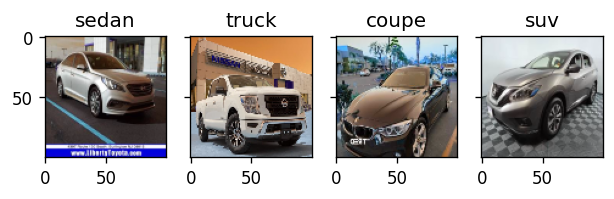

In [57]:
#  Displaying random images
figure, axes = plt.subplots(1,4, dpi=120, sharey=True)
axes[0].imshow(dataset[2457][0])
axes[0].set_title('sedan')
axes[1].imshow(dataset[4756][0])
axes[1].set_title('truck')
axes[2].imshow(dataset[23967][0])
axes[2].set_title('coupe')
axes[3].imshow(dataset[23979][0])
axes[3].set_title('suv')

In [70]:
#  defining splitting function
def train_val_split(dataset_to_split, val_pct):
  #  deriving dataset length
  number_of_instances = len(dataset_to_split)
  #  deriving length of validattion set
  val_idx = int(number_of_instances*val_pct)
  #  deriving random permutations of the whole dataset
  idx = list(np.random.permutation(number_of_instances))
  return idx[:val_idx], idx[val_idx:]

#  creating testing, validation and training indices
test_indices, dataset_indices = train_val_split(dataset, 0.1)
val_indices, train_indices = train_val_split(dataset_indices, 0.2)

In [ ]:
#  splitting dataset
training_data = dataset[train_indices]
validation_data = dataset[val_indices]
testing_data = dataset[test_indices]

#  extracting and scaling features and labels
X_train = [x[0]/255 for x in training_data]
y_train = [x[1] for x in training_data]

X_val = [x[0]/255 for x in validation_data]
y_val = [x[1] for x in validation_data]

X_test = [x[0]/255 for x in testing_data]
y_test = [x[1] for x in testing_data]

#  converting to tensor
X_train = torch.Tensor(np.array(X_train))
y_train = torch.Tensor(np.array(y_train))
X_val = torch.Tensor(np.array(X_val))
y_val = torch.Tensor(np.array(y_val))
X_test = torch.Tensor(np.array(X_test))
y_test = torch.Tensor(np.array(y_test))

In [113]:
arr1 = np.eye(3)
arr2 = np.eye(3)

eggs = [[arr1, 0], [arr2, 1]]

[array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]), 0]